In [44]:
!pip install emoji
!pip install transformers
!pip install tensorflow
!pip install keras
!pip install pydot
!pip install pandas
!pip install seaborn
!pip install wordcloud

In [2]:
import re

import pandas as pd
import emoji
pd.set_option("display.max_columns", None)
pd.set_option("display.max_row", 100)

import seaborn as sns
# Réglage seaborn
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context(rc={'patch.linewidth': 0.2})
sns.set_palette("hls", 8)

import numpy as np

In [3]:
tweets = pd.read_csv('Tweets.csv')

In [4]:
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Exploratory Data Analysis (EDA)

In [6]:
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

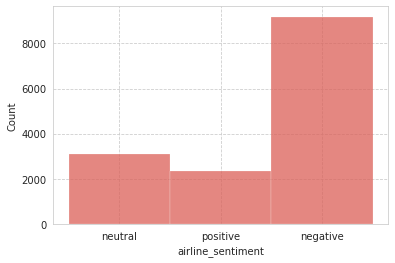

In [7]:
sns.histplot(x='airline_sentiment', data=tweets)

Very imbalanced dataset, majority of negative samples.

- We are going to keep only negative and positive sentiment and discard neutral ones 
- We kepp the dataset imbalance because this is not the aim of the notebook, though we make sure to use balanced_accuracy as a metric 

In [8]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral']

In [9]:
tweets.query('airline_sentiment == "negative"')['negativereason'].unique()

array(['Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [10]:
tweets.query('airline_sentiment == "negative"')['negativereason'].isna().value_counts()

False    9178
Name: negativereason, dtype: int64

Every negative samples has a reason, but one value is Can't tell

In [11]:
neg_value = tweets['negativereason'].value_counts()
percent =  round(tweets['negativereason'].value_counts() / len(tweets.query('airline_sentiment == "negative"')),2).mul(100).astype('str') + "%"
pd.DataFrame({'Neg value counts' : neg_value, 'Percentage' : percent})

,Neg value counts,Percentage
Customer Service Issue,2910,32.0%
Late Flight,1665,18.0%
Can't Tell,1190,13.0%
Cancelled Flight,847,9.0%
Lost Luggage,724,8.0%
Bad Flight,580,6.0%
Flight Booking Problems,529,6.0%
Flight Attendant Complaints,481,5.0%
longlines,178,2.0%
Damaged Luggage,74,1.0%


- 13% of negative reviews have the Can't Tell value
- The majority (32%) of negative reviews is due to customer service issue
- Very few (1%) reviews are due to damaged luggage, but a bit more are caused by lost luggage (8%)

(-0.5, 399.5, 199.5, -0.5)

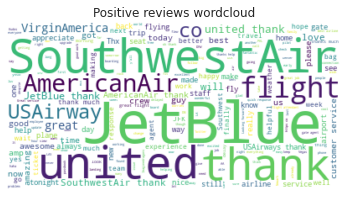

In [57]:
# Let's do a bit of visualisation, i love wordclouds when it comes to NLP
from wordcloud import WordCloud
reviews = tweets.loc[tweets['airline_sentiment'] == "positive",'text']
text = " ".join(review for review in reviews)
wordcloud = WordCloud(background_color="white").generate(text)
plt.title("Positive reviews wordcloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


(-0.5, 399.5, 199.5, -0.5)

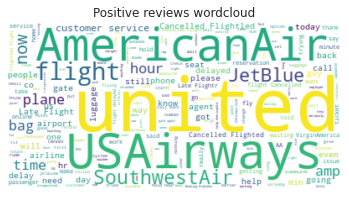

In [56]:
from wordcloud import WordCloud
reviews = tweets.loc[tweets['airline_sentiment'] == "negative",'text']
text = " ".join(review for review in reviews)
wordcloud = WordCloud(background_color="white").generate(text)
plt.title("Negative reviews wordcloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Most used words are airline company names
but we can see words like delay, late flight, cancelled in negative reviews and thank, hope, great, good, appreciate in positive reviews

In [52]:
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_clean,num_words
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've add commercials to the experience....,8
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""ent...",16
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it,9
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),seriously would pay $30 a flight for seat that...,22
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),"yes, nearly every time i fly vx this “ear worm...",14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14633,569587705937600512,0,1.0000,Cancelled Flight,1.0000,American,NaN,RussellsWriting,NaN,0,@AmericanAir my flight was Cancelled Flightled...,NaN,2015-02-22 12:01:06 -0800,Los Angeles,Arizona,"my flight be cancel flightled, leave tomorrow ...",20
14634,569587691626622976,0,0.6684,Late Flight,0.6684,American,NaN,GolfWithWoody,NaN,0,@AmericanAir right on cue with the delays👌,NaN,2015-02-22 12:01:02 -0800,NaN,Quito,right on cue with the delays:OK_hand:,6
14635,569587686496825344,1,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN,thank you we get on a different flight to chic...,10
14636,569587371693355008,0,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN,leave over 20 minutes late flight. no warn or ...,22


# Preprocessing tweets

In [12]:
tweets.loc[:,'text']

1        @VirginAmerica plus you've added commercials t...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
5        @VirginAmerica seriously would pay $30 a fligh...
6        @VirginAmerica yes, nearly every time I fly VX...
                               ...                        
14633    @AmericanAir my flight was Cancelled Flightled...
14634           @AmericanAir right on cue with the delays👌
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14638    @AmericanAir you have my money, you change my ...
Name: text, Length: 11541, dtype: object

In [13]:
!pip install nltk

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr=WordNetLemmatizer()
stop_words=stopwords.words("english")

In [15]:
def clean_text(text):
    
    #Put text into lower case
    text=text.lower()
    
    #Remove URLs
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    #Remove Hashtags
    text = re.sub(r"#", "", text)
                  
    #Remove Mentions
    text = re.sub(r"@\S+", "", text)
    
    #Handling Emojis/Emoticons
    text=emoji.demojize(text)
    
    emoticons = dict()
    emoticons['EMOT_SMILEY']=[':-)', ':)', '(:', '(-:', ';p', ':-d', ':d',]
    emoticons['EMOT_LAUGH']=[':-D', ':D', 'X-D', 'XD', 'xD']
    emoticons['EMOT_LOVE']=['<3', ':\*',]
    emoticons['EMOT_CRY']=[':,(', ':\'(', ':"(', ':((']
    emoticons['EMOT_WINK']=[';-)', ';)', ';-D', ';D', '(;', '(-;']
    emoticons['EMOT_FROWN']=[':-(', ':(']
    for label,emot in emoticons.items():
        for word in text.split():
            if word in emot:
                text=text.replace(word,label)
    #Lemmatazation
    text=' '.join([lmtzr.lemmatize(word,'v') for word in text.split()])
    return text
    

In [16]:
tweets = tweets.assign(text_clean = tweets['text'].apply(lambda x : clean_text(x)))

In [17]:
tweets.loc[:,['text','text_clean']]

,text,text_clean
1,@VirginAmerica plus you've added commercials t...,plus you've add commercials to the experience....
3,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent..."
4,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay $30 a flight for seat that...
6,"@VirginAmerica yes, nearly every time I fly VX...","yes, nearly every time i fly vx this “ear worm..."
...,...,...
14633,@AmericanAir my flight was Cancelled Flightled...,"my flight be cancel flightled, leave tomorrow ..."
14634,@AmericanAir right on cue with the delays👌,right on cue with the delays:OK_hand:
14635,@AmericanAir thank you we got on a different f...,thank you we get on a different flight to chic...
14636,@AmericanAir leaving over 20 minutes Late Flig...,leave over 20 minutes late flight. no warn or ...


Let's visualize wordclouds now that text has been preprocessed

(-0.5, 399.5, 199.5, -0.5)

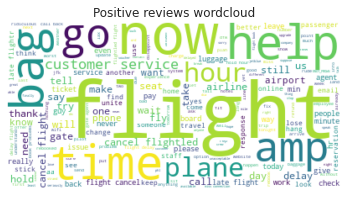

In [59]:
from wordcloud import WordCloud
reviews = tweets.loc[tweets['airline_sentiment'] == 0,'text_clean']
text = " ".join(review for review in reviews)
wordcloud = WordCloud(background_color="white").generate(text)
plt.title("Negative reviews wordcloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

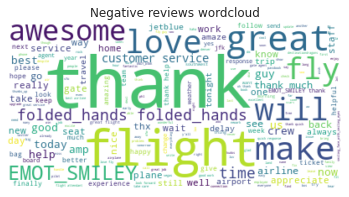

In [61]:
from wordcloud import WordCloud
reviews = tweets.loc[tweets['airline_sentiment'] == 1,'text_clean']
text = " ".join(review for review in reviews)
wordcloud = WordCloud(background_color="white").generate(text)
plt.title("Postive reviews wordcloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


Well, now the wordclouds are much more meaningful !

In [18]:
# This line gets the number of word in each cleaned tweets (in order to get the max)
tweets = tweets.assign(num_words = tweets['text_clean'].apply(lambda x : len(x.split(' '))))

(array([5.570e+02, 6.910e+02, 1.189e+03, 1.136e+03, 1.458e+03, 2.755e+03,
        2.329e+03, 1.324e+03, 1.000e+02, 2.000e+00]),
 array([ 1. ,  4.4,  7.8, 11.2, 14.6, 18. , 21.4, 24.8, 28.2, 31.6, 35. ]),
 <a list of 10 Patch objects>)

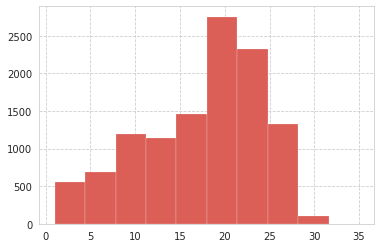

In [41]:
plt.hist(tweets['num_words'])

Most tweets are between 15 and 25 words

In [19]:
max_words = tweets['num_words'].max()

In [20]:
tweets['airline_sentiment'] = tweets['airline_sentiment'].astype('category')
encoded_dict = {'negative' : 0, 'positive' : 1}

tweets['airline_sentiment'] = tweets['airline_sentiment'].cat.codes

In [21]:
X = tweets['text_clean'].values.reshape(-1,1)
y = tweets['airline_sentiment'].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

print(f'Length of X_train : {len(X_train)}, Length of X_test : {X_test.shape[0]}')

Length of X_train : 9232, Length of X_test : 2309


Splitting the dataset into train/test (80%/20%)

We don't use validation set because we will not implement hyperparameter tuning here

# Transformers ! 

In [22]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', num_labels=2)
bert = TFBertModel.from_pretrained('distilbert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'distilbert', 'activation_13']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
tokenizer('Hello my name is pierre')

{'input_ids': [101, 7592, 2026, 2171, 2003, 5578, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

We tokenize our train and test set

In [24]:
X_train = tokenizer(
        text=X_train.reshape(-1).tolist(),
        add_special_tokens=True,
        max_length=max_words,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)


X_test = tokenizer(
        text=X_test.reshape(-1).tolist(),
        add_special_tokens=True,
        max_length=max_words,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)

In [25]:
X_train['input_ids']

<tf.Tensor: shape=(9232, 35), dtype=int32, numpy=
array([[  101,  2178,  2757, ...,  2620,  1006,   102],
       [  101, 18744,  2575, ...,  2341,   999,   102],
       [  101,  3524,  2005, ...,     0,     0,     0],
       ...,
       [  101,  8403,   999, ...,     0,     0,     0],
       [  101,  3100,  4067, ...,     0,     0,     0],
       [  101,  2022,  2023, ...,     0,     0,     0]], dtype=int32)>

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

In [27]:
max_len = max_words

input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

bert_inputs = {'input_ids': input_ids, 'input_mask': input_mask}

embeddings = bert.bert(input_ids, attention_mask=input_mask)[0] #Here 0 is the last hidden states
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(512, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)

# Last layer
y = Dense(2, activation = 'softmax')(out) #Here 2 because we got 2 categories to predict and softmax because we want probabilities
model = tf.keras.Model(inputs=bert_inputs, outputs=y)



In [29]:
opt = Adam(learning_rate=2e-5, epsilon=1e-8)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) #From logits
metric = CategoricalAccuracy('balanced_accuracy')

In [30]:
model.compile(optimizer=opt, loss=loss, metrics=metric)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 35)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 35)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 35,                                            

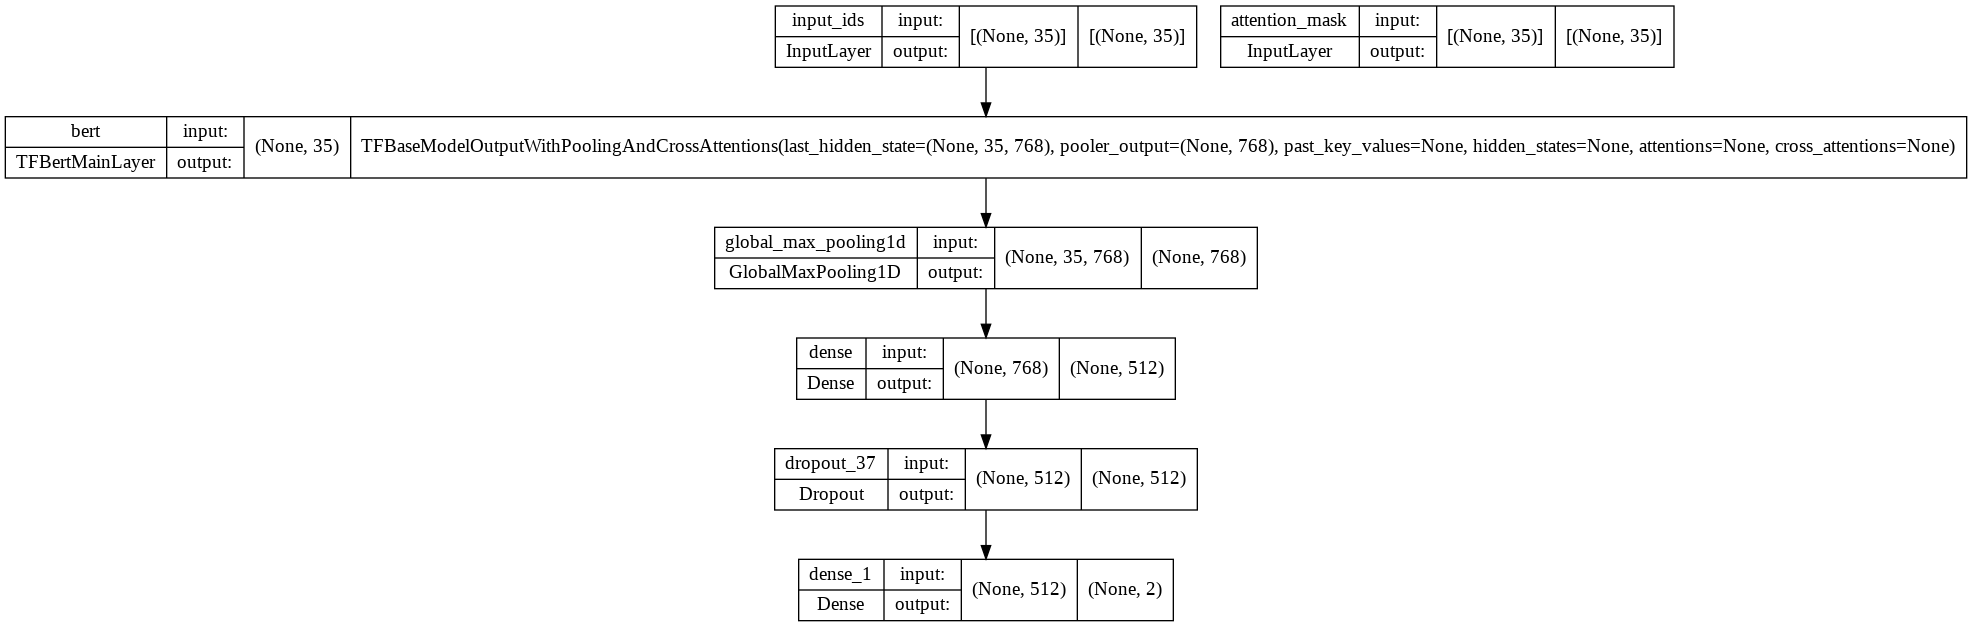

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
batch_size = 32
num_epochs = 3

train_history = model.fit(
    x={'input_ids' : X_train['input_ids'],'input_mask' : X_train['attention_mask']},
    y=to_categorical(y_train),
    validation_data=({'input_ids' : X_test['input_ids'],'input_mask' : X_test['attention_mask']},to_categorical(y_test)),
    epochs=num_epochs, batch_size=batch_size)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


289/289 [==============================] - 3372s 12s/step - loss: 0.4115 - balanced_accuracy: 0.8348 - val_loss: 0.3163 - val_balanced_accuracy: 0.8805
Epoch 2/3
289/289 [==============================] - 3175s 11s/step - loss: 0.2544 - balanced_accuracy: 0.8980 - val_loss: 0.2214 - val_balanced_accuracy: 0.9078
Epoch 3/3
289/289 [==============================] - 3206s 11s/step - loss: 0.1901 - balanced_accuracy: 0.9268 - val_loss: 0.2223 - val_balanced_accuracy: 0.9194


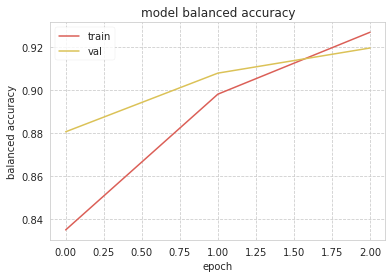

In [34]:
from matplotlib import pyplot as plt
plt.plot(train_history.history['balanced_accuracy'])
plt.plot(train_history.history['val_balanced_accuracy'])
plt.title('model balanced accuracy')
plt.ylabel('balanced accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
from sklearn.metrics import classification_report

y_pred = model.predict({'input_ids' : X_test['input_ids'],'input_mask' : X_test['attention_mask']})

In [36]:
predicted_sentiment = np.argmax(y_pred, axis=1)

In [39]:
print(classification_report(y_test, predicted_sentiment))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1862
           1       0.89      0.67      0.76       447

    accuracy                           0.92      2309
   macro avg       0.91      0.82      0.86      2309
weighted avg       0.92      0.92      0.91      2309



We could train the model a bit more, tune hyperparameters, manage overfitting with callbacks etc .. But it's enough for now ! The goal of fine tuning a bert model has been achieved, let's save the weight so we can re-use it in an app

In [40]:
#We save the weights to re-use the model in an app
model.save_weights('/root/sentiment_weights.h5')